# Exploring the UTx000 Extension EMA Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# Sleep Survey Data Restriction
Similar to restricting the data over periods when we have gps data, this notebook looks at the sleep surveys that we have received and restricts the beacon data to nights that preceded these surveys.

## Package Import

In [1]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

## Data Import

### Survey Data

In [2]:
sleep_survey = pd.read_csv('../data/processed/bpeace2-morning-survey.csv',index_col=0,parse_dates=True)
sleep_survey.head()

,ID,Content,Stress,Lonely,Sad,Energy,TST,SOL,NAW,Restful
2020-07-31 14:25:00,hfttkth7,1,2,1.0,3,0,6.0,10.0,3.0,0
2020-08-20 03:49:00,hfttkth7,1,1,0.0,1,2,7.0,20.0,1.0,1
2020-08-23 15:58:00,hfttkth7,1,1,1.0,2,0,6.0,25.0,0.0,0
2020-07-17 14:52:00,hfttkth7,1,1,0.0,1,2,7.0,20.0,3.0,2
2020-08-12 17:32:00,hfttkth7,1,3,1.0,2,2,6.0,20.0,0.0,1


# Analyzing the Morning Survey Data
Taking a closer look at what data are available for morning/sleep surveys.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def label_hist(n, bins):
    '''
    Labels the histogram with values above the bars
    
    Inputs:
    - n: the counts for each bin
    - bins: the actual bins limits
    
    Returns void
    '''
    k = []
    # calculate the relative frequency of each bin
    for i in range(0,len(n)):
        k.append(round((bins[i+1]-bins[i])*n[i],0))

    # plot the label/text to each bin
    for i in range(0, len(n)):
        x_pos = bins[i] + (bins[i+1] - bins[i]) / 2
        y_pos = n[i]
        label = str(k[i])[:-2] # relative frequency of each bin
        ax.text(x_pos, y_pos, label, ha='center', va='bottom')

## Mood
Mood questions are those that ask about the participants contentment, stress, loneliness, sadness, and energy levels.

### Histogram

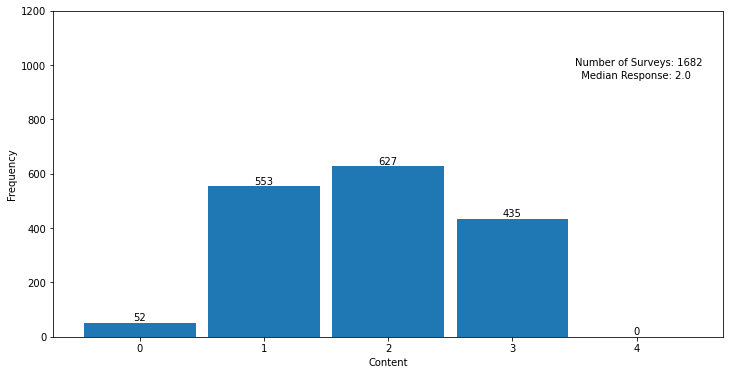

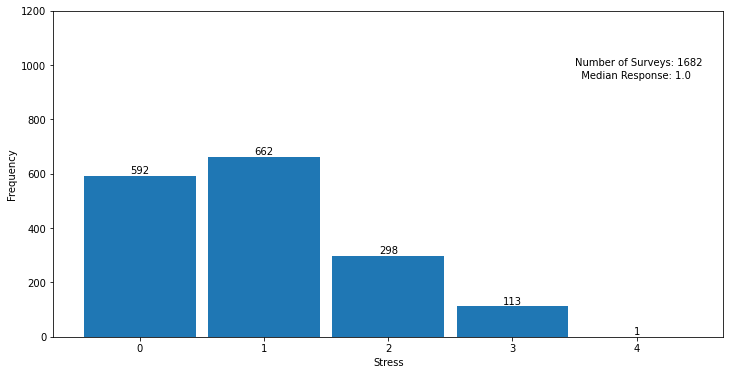

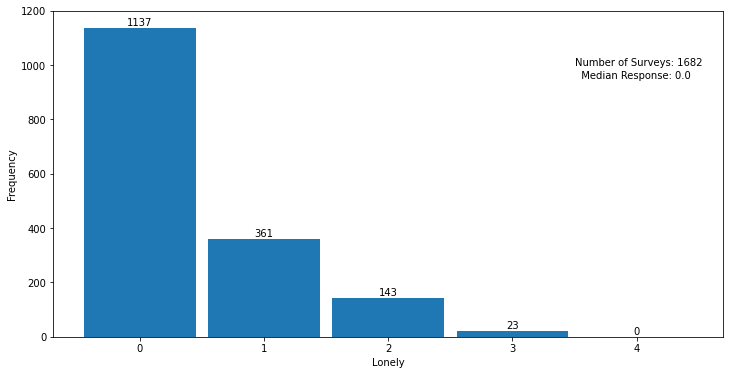

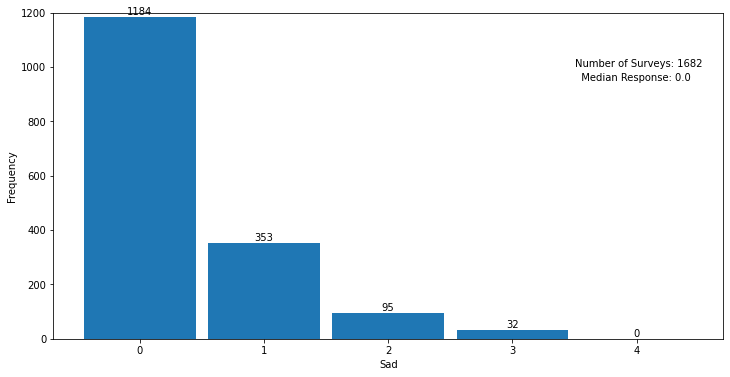

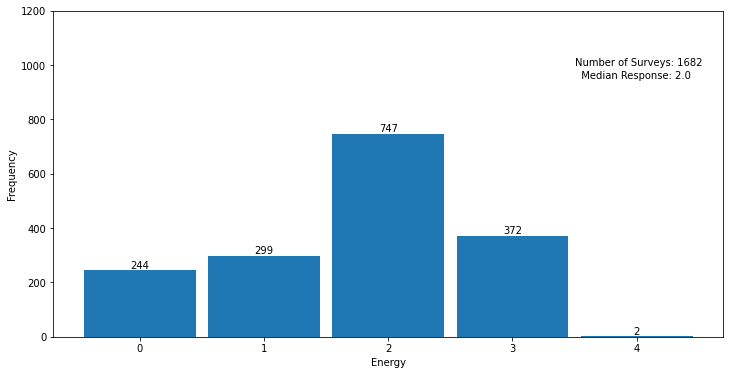

In [5]:
for question in ['Content','Stress','Lonely','Sad','Energy']:
    fig, ax = plt.subplots(figsize=(12,6))
    n,bins,patches = plt.hist(sleep_survey[question],bins=[-0.5,0.5,1.5,2.5,3.5,4.5],rwidth=0.9)
    ax.set_xlabel(question)
    ax.set_ylabel('Frequency')
    ax.set_ylim([0,1200])
    
    ax.text(3.5,1000,f'Number of Surveys: {len(sleep_survey[question])}')
    ax.text(3.5,950,f'  Median Response: {np.nanmedian(sleep_survey[question])}')
    
    label_hist(n, bins)
        
    plt.show()
    plt.close()

## Sleep
Sleep portions of the survey includes:
- TST: total sleep time
- SOL: sleep onset latency
- NAW: number of awakenings
- Restful: Likert scale 0-3

In [6]:
import scipy.stats as st

### General Histogram

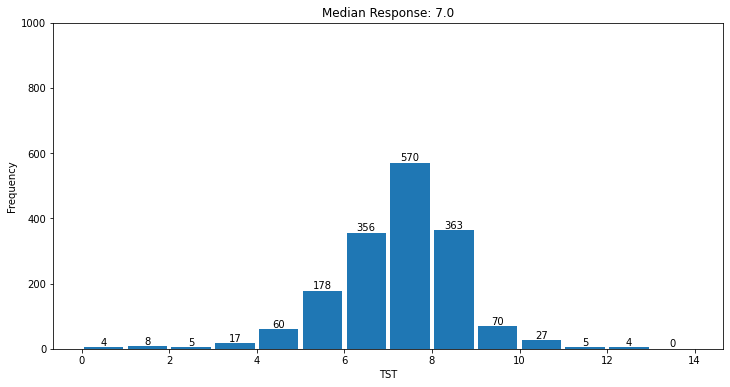

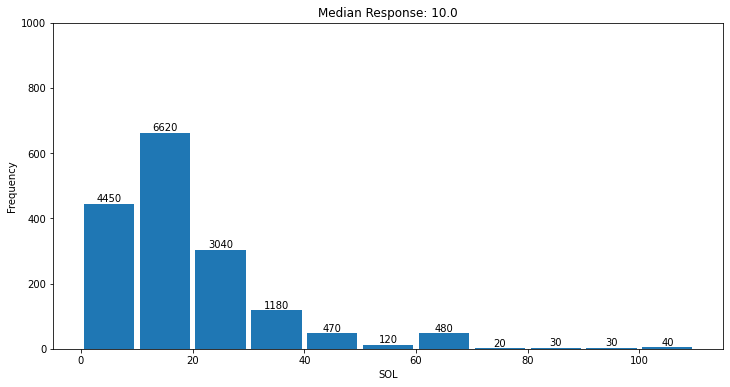

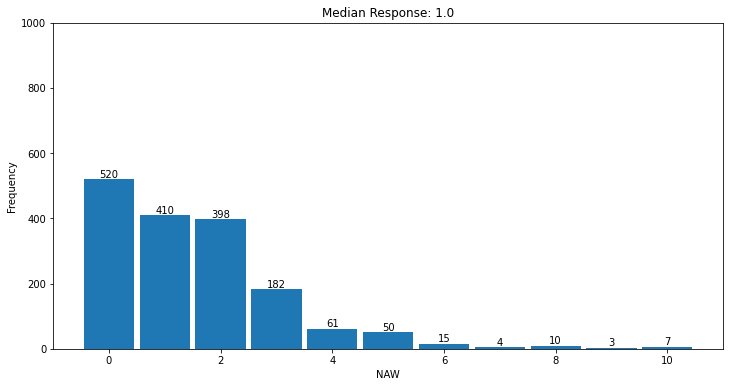

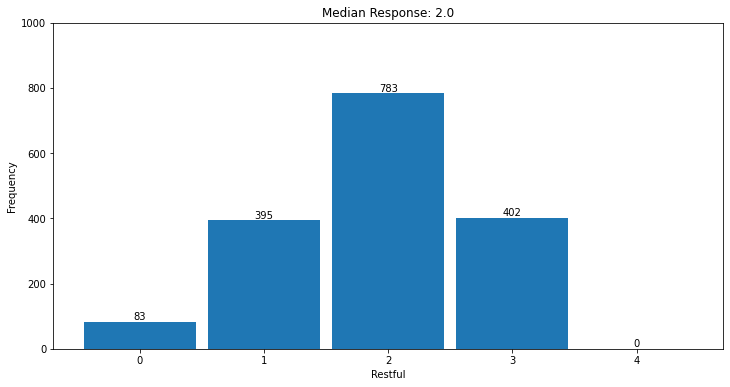

In [7]:
questions = ['TST','SOL','NAW','Restful']
bin_list = [np.arange(0,15,1),
           np.arange(0,120,10),
           np.arange(-0.5,11.5,1),
           [-0.5,0.5,1.5,2.5,3.5,4.5]]

for question, bins in zip(questions, bin_list):
    fig, ax = plt.subplots(figsize=(12,6))
    n,bins,patches = plt.hist(sleep_survey[question],bins=bins,rwidth=0.9,align='mid')
    ax.set_xlabel(question)
    ax.set_ylabel('Frequency')
    ax.set_ylim([0,1000])
    
    ax.set_title(f'Median Response: {np.nanmedian(sleep_survey[question])}')
    
    label_hist(n, bins)
        
    plt.show()
    plt.close()

### Per Participant Responses

In [8]:
first_date = datetime(2020,5,13) # beiwe surveys were fixed this day
end_date = datetime(2020,9,1) # this was the first sampling appointment - some pts might have turned off beiwe
maxDailySurveys = np.busday_count(first_date.date(), end_date.date(), weekmask='Sun Mon Wed Fri')
print(f'Maximum \"Daily\" Surveys: {maxDailySurveys}')
maxWeeklySurveys = np.busday_count(first_date.date(), end_date.date(), weekmask='Sat')
print(f'Maximum Weekly Surveys: {maxWeeklySurveys}')

Maximum "Daily" Surveys: 64
Maximum Weekly Surveys: 16


In [9]:
# Number of surveys submitted
bid = []
surveys_submitted = []
# Looping through beacon participants only
for beiwe in beacon_data['Beiwe'].unique():
    survey_by_beiwe = sleep_survey[sleep_survey['ID'] == beiwe]
    bid.append(beiwe)
    surveys_submitted.append(len(survey_by_beiwe))

fig, ax = plt.subplots(figsize=(16,4))
# scattering number of surveys submitted per participant
ax.scatter(bid,surveys_submitted,s=50,zorder=10)
ax.set_yticks(np.arange(0,70,10))
plt.xticks(rotation=-30)
ax.grid(zorder=1)
# adding average line
ax.axhline(np.nanmean(surveys_submitted),color='red',linestyle='dashed')
ax.text(bid[2],np.nanmean(surveys_submitted),'average',va='top',ha='center',color='red')
#percentage
plt.show()
plt.close()

NameError: name 'beacon_data' is not defined

### Differences in the Day of the Week


In [ ]:
# grouping by night sleep (survey date - 1 day)
sleep_survey['DoW'] = (sleep_survey.index - timedelta(days=1)).strftime('%a')
# all participants
sleep_survey_dow = sleep_survey.groupby(['DoW']).mean()
sleep_survey_dow = sleep_survey_dow.reindex(["Mon", "Tue", "Wed","Thu","Fri","Sat",'Sun'])
# beacon-holding participants only
sleep_survey_restricted = sleep_survey[sleep_survey['ID'].isin(bid)]
sleep_survey_dow_beacon = sleep_survey_restricted.groupby(['DoW']).mean()
sleep_survey_dow_beacon = sleep_survey_dow_beacon.reindex(["Mon", "Tue", "Wed","Thu","Fri","Sat",'Sun'])
# looping through both dataframes
for df, restricted in zip([sleep_survey_dow,sleep_survey_dow_beacon],[False,True]):
    print(f'Restricted to Beacon Participants Only: {restricted}')
    fig, axes = plt.subplots(4,1,figsize=(12,10),sharex=True)
    i=0
    limits = [[5,9],[10,30],[0,3],[0,3]]
    for question, limit, ylabel in zip(['TST','SOL','NAW','Restful'],limits,['hours','minutes','number','score']):

        sleep_survey_dow_plot = df[df[question] >= 0]
        # Scattering for day of week
        axes[i].scatter(sleep_survey_dow_plot.index,sleep_survey_dow_plot[question],s=25,color='black',zorder=10)
        axes[i].set_title(question)
        axes[i].set_ylim(limit)
        axes[i].set_ylabel(ylabel)

        # Adding 95% CI
        for day in sleep_survey['DoW'].unique():
            sleep_survey_by_day = sleep_survey[sleep_survey['DoW'] == day]
            if restricted:
                sleep_survey_by_day = sleep_survey_by_day[sleep_survey_by_day['ID'].isin(bid)]

            sleep_survey_by_day = sleep_survey_by_day[sleep_survey_by_day[question] >= 0]
            ci = st.t.interval(0.95, len(sleep_survey_by_day[question])-1,
                          loc=np.mean(sleep_survey_by_day[question]),
                          scale=st.sem(sleep_survey_by_day[question]))

            axes[i].plot([day,day],ci,color='red',zorder=1) 
            # adding number of surveys on top figure
            if question == 'TST':
                axes[i].text('Mon',8,'n:   ',ha='right')
                axes[i].text(day,8,len(sleep_survey_by_day))
        i += 1

    plt.subplots_adjust(wspace=0,hspace=0.2)
    plt.show()
    plt.close()

### Per Participant Responses

In [ ]:
# Sleep metrics
fig, axes = plt.subplots(4,1,figsize=(16,16),sharex=True)
sleep_survey_restricted = sleep_survey[sleep_survey['ID'].isin(bid)]
i = 0
for question, ylabel in zip(['TST','SOL','NAW','Restful'],['hours','minutes','number','score']):
    sleep_survey_restricted_plot = sleep_survey_restricted[sleep_survey_restricted[question] >= 0]
    sns.stripplot(x='ID',y=question,data=sleep_survey_restricted_plot,color='black',alpha=0.1,ax=axes[i])
    axes[i].set_xlabel('')
    axes[i].set_ylabel(ylabel)
    axes[i].set_title(question)
    
    i += 1
    
plt.xticks(rotation=-30)
plt.subplots_adjust(hspace=0.2)
plt.show()
plt.close()